In [1]:
# Libs to catch and treat data:
import tweepy           
import pandas as pd    
import numpy as np      
import collections
import re
from os import listdir, mkdir, utime
from os.path import isfile, join, exists

# Libs for plotting and visualization:
from wordcloud import WordCloud
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#%matplotlib TkAgg

# getting access keys saved at credentials.py:
from credentials import *

In [2]:
# API Setup
def twitter_setup():
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    return api

In [49]:
api = twitter_setup()
tweets = tweepy.models.ResultSet()
twitter_profile = '@who'

for i in range(3):
    tweets += api.user_timeline(screen_name=twitter_profile, count=200, page=i)
print(f'Tweets obtained: {len(tweets)}.')

#tweets = api.user_timeline(screen_name='@jairbolsonaro', count=200)

print('The first 5 tweets:')
for tweet in tweets[:5]:
    print(tweet.text)
    print()

Tweets obtained: 600.
The first 5 tweets:
WHO declared #COVID19 a Public Health Emergency of International Concern on 30 January 2020, when there were less t… https://t.co/OkJ1hmSV1Z

#OpenWHO, the free, open-access learning platform for health emergencies, now offers 9 online courses related to… https://t.co/E9OUA9vWxX

@palkisu @DrTedros .@palkisu we don't see you online. If you join, we will take your question. 
https://t.co/ZTkjLQ4iKo

"We’re all in this together. And we will only get through it together"-@DrTedros #COVID19 

The full statement: https://t.co/tLkdaJm0Q3

"Earlier today I spoke to health ministers from across the Eastern Mediterranean region.

I assured them that we wi… https://t.co/gko24hSFJp



In [50]:
df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
display(df.head())

,Tweets
0,WHO declared #COVID19 a Public Health Emergenc...
1,"#OpenWHO, the free, open-access learning platf..."
2,@palkisu @DrTedros .@palkisu we don't see you ...
3,"""We’re all in this together. And we will only ..."
4,"""Earlier today I spoke to health ministers fro..."


Let's take a look at the internal methods and variables available.

In [51]:
print(dir(tweets[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'parse', 'parse_list', 'place', 'possibly_sensitive', 'retweet', 'retweet_count', 'retweeted', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


From here we can select some relevant variables like: id, created_at, source, favorite_count, retweet_count

In [52]:
print(tweets[0].place)

None


In [53]:
df['Size'] = np.array([len(tweet.text) for tweet in tweets])
df['Id'] = np.array([tweet.id for tweet in tweets])
df['Created at'] = np.array([tweet.created_at for tweet in tweets])
df['Source'] = np.array([tweet.source for tweet in tweets])
df['Likes'] = np.array([tweet.favorite_count for tweet in tweets])
df['Retweets'] = np.array([tweet.retweet_count for tweet in tweets])

In [54]:
display(df[80:100])

,Tweets,Size,Id,Created at,Source,Likes,Retweets
80,"In pregnant women, #IronDeficiency can cause a...",129,1252571683535421440,2020-04-21 12:15:35,Twitter Web App,322,85
81,"In adults, #IronDeficiency can have negative e...",140,1252546539844706304,2020-04-21 10:35:40,Twitter Web App,453,126
82,The whole WHO family is saddened by the news t...,140,1252527311783673856,2020-04-21 09:19:16,Twitter Web App,678,166
83,The cognitive development of a child can also ...,139,1252522226261377024,2020-04-21 08:59:04,Twitter Web App,311,80
84,RT @WHOSEARO: Older adults &amp; people with u...,144,1252516038480142342,2020-04-21 08:34:28,Twitter Web App,0,134
85,#IronDeficiency in children under two years of...,140,1252506930741993473,2020-04-21 07:58:17,Twitter Web App,293,108
86,Detecting #IronDeficiency early during pregnan...,129,1252491797902831616,2020-04-21 06:58:09,Twitter Web App,274,67
87,RT @DrTedros: Beautiful art for the start of t...,133,1252488918148296705,2020-04-21 06:46:42,Twitter for iPhone,0,311
88,@THumanics @pahowho @WHOEMRO @WHOAFRO @WHOSEAR...,140,1252485145401196546,2020-04-21 06:31:43,Twitter Web App,2,0
89,#IronDeficiency occurs mainly when the require...,140,1252483889219633152,2020-04-21 06:26:43,Twitter Web App,411,117


Now let's analyze some statistics and basic information like mean size of tweets, tweets with more likes and tweets with more retweets.

In [55]:
mean_size = np.mean(df['Size'])

most_liked = np.max(df['Likes'])
most_retweeted = np.max(df['Retweets'])

most_liked_index = df[df.Likes == most_liked].index[0]
most_retweeted_index = df[df.Retweets == most_retweeted].index[0]


print(f'Tweet with more Likes:\n{df["Tweets"][most_liked_index]}')
print(f'Qtd. Likes: {most_liked}')
print(f'Qtd. Characters: {df["Size"][most_liked_index]}\n')

print(f'Tweet with more Retweets:\n{df["Tweets"][most_retweeted_index]}')
print(f'Qtd. Likes: {most_retweeted}')
print(f'Qtd. Characters: {df["Size"][most_retweeted_index]}')

Tweet with more Likes:
LIVE: One world, #TogetherAtHome! #COVID19 https://t.co/kHCdwCHKwf
Qtd. Likes: 10106
Qtd. Characters: 66

Tweet with more Retweets:
RT @WHO: LIVE: One world, #TogetherAtHome! #COVID19 https://t.co/kHCdwCHKwf
Qtd. Likes: 5059
Qtd. Characters: 75


In [56]:
ts_size = pd.Series(data=df['Size'].values, index=df['Created at'])
ts_likes = pd.Series(data=df['Likes'].values, index=df['Created at'])
ts_retweets = pd.Series(data=df['Retweets'].values, index=df['Created at'])

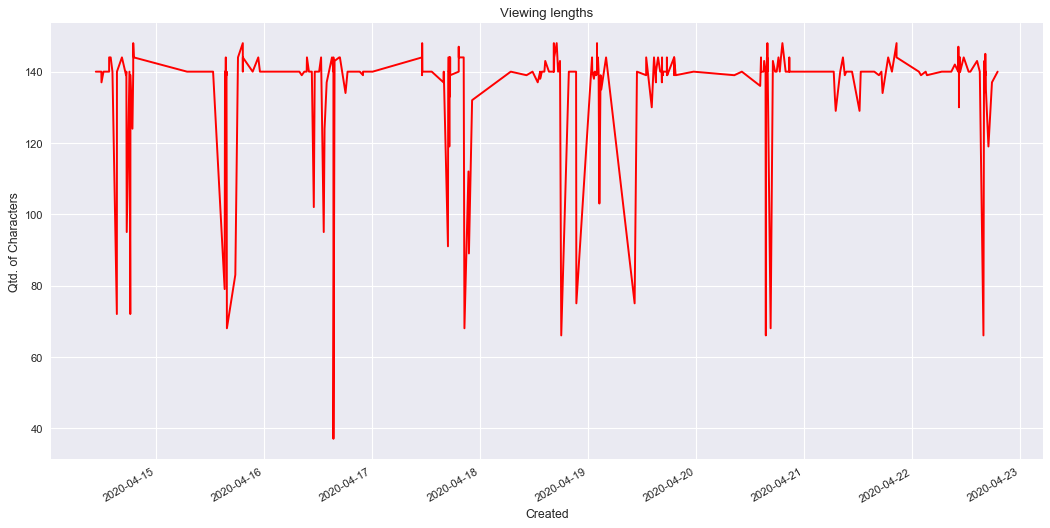

In [57]:
plt.figure(figsize=(16, 8), dpi=80)
ts_size.plot(color='r')
plt.xlabel('Created')
plt.ylabel('Qtd. of Characters')
plt.title('Viewing lengths')
plt.show()

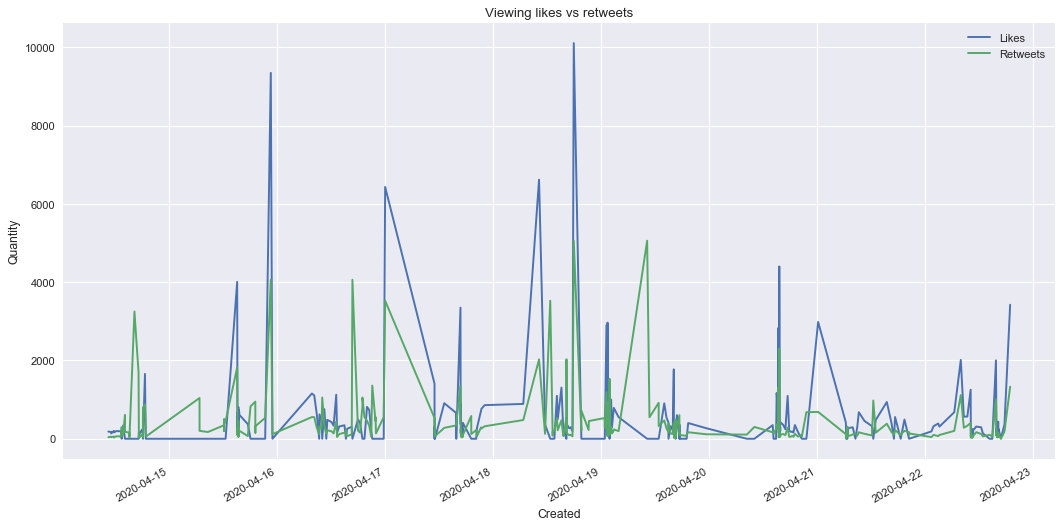

In [58]:
plt.figure(figsize=(16, 8), dpi=80)
ts_likes.plot(label="Likes", legend=True)
ts_retweets.plot(label="Retweets", legend=True);
plt.xlabel('Created')
plt.ylabel('Quantity')
plt.title('Viewing likes vs retweets')
plt.show()

In [59]:
#  Get possible sources:
sources = []
for source in df['Source']:
    if source not in sources:
        sources.append(source)

# Print sources:
print("Content creation sources:")
for source in sources:
    print(f'* {source}')

Content creation sources:
* Twitter for iPhone
* Twitter Web App
* Periscope


In [60]:
source

'Periscope'

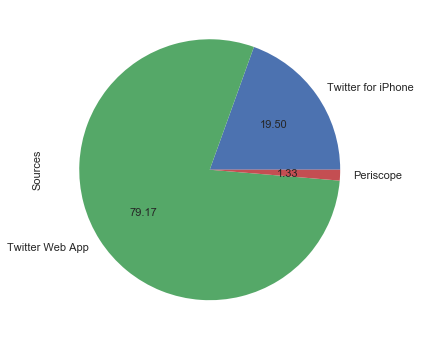

In [61]:
percent = np.zeros(len(sources))

for source in df['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100

# Pie chart:
pie_chart = pd.Series(percent, index=sources, name='Sources')
pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(6, 6));

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
count_matrix = cv.fit_transform(df.Tweets)
word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,the,538
1,co,471
2,to,466
3,https,461
4,of,274
5,and,235
6,covid19,203
7,who,197
8,in,174
9,we,168


In [93]:
#stopwords = set(line.strip() for line in open('stopwords.txt'))
#stopwords = stopwords.union(set(['https', 'co', 'os', 'rt', '04', '20', '000', '600', '03', '10', 'não', 'já', 'nesta', 'são']))
stopwords = set(STOPWORDS)
stopwords = stopwords.union(set(['https', 'co', 'rt', 'one', 're', 've', 'will', 'un', 'amp']))


In [94]:
wordcount = collections.defaultdict(int)
for word in stopwords:
    word_count = word_count[word_count.word != word]        

In [95]:
word_count[:60]

,word,count
6,covid19,203
12,drtedros,143
19,countries,82
22,health,69
27,world,56
29,support,47
34,people,40
36,response,40
41,working,36
46,today,32


<Figure size 1280x640 with 0 Axes>

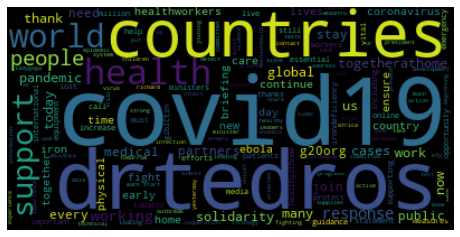

In [96]:
wordcount = collections.defaultdict(int)
wordcount = word_count.set_index('word')['count'].to_dict()
wc = WordCloud().generate_from_frequencies(wordcount)
plt.figure(figsize=(16, 8), dpi=80)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [97]:
text = ''
for word in word_count['word']:
    text += word + ' '
    

In [98]:
import os
from PIL import Image
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
path = ''
brazil_mask = np.array(Image.open(path.join("globe_mask.png")))

In [99]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

from wordcloud import WordCloud, STOPWORDS

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
brazil_mask = np.array(Image.open("globe_mask.png"))
brazil_mask = brazil_mask[:,:,0]

In [100]:
brazil_mask.shape

(1193, 2483)

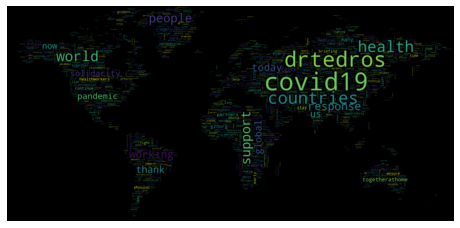

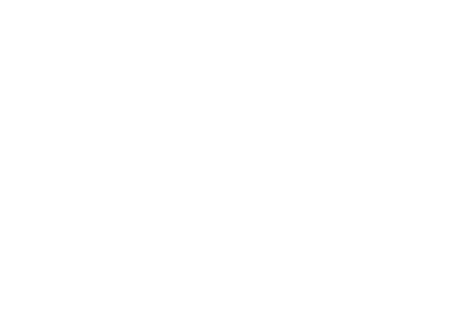

In [101]:
wc = WordCloud(background_color="black", max_words=2000, mask=brazil_mask,
               stopwords=stopwords, contour_width=3, contour_color='black')

# generate word cloud
wc.generate_from_frequencies(wordcount)
# store to file
wc.to_file(path.join("brainstorm.png"))

# show
#plt.figure(figsize=(25, 8), dpi=300)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
#plt.imshow(brazil_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

In [102]:
from textblob import TextBlob

def limpia_tweet(tweet):
    '''
    Función de utilidad para limpiar el texto de un tweet removiendo 
    enlaces y caracteres especiales usando regex.
    '''
    #return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", tweet).split())

    
def analiza_sentimiento(tweet):
    '''
    Función de utilidad para clasificar el sentimiento del tweet
    proporcionado utilizando textblob
    '''
    #print(tweet)
    print('')
    analysis = TextBlob(limpia_tweet(tweet))
    
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [105]:
# Creamos columna de resultados del análisis
df['AdS'] = np.array([ analiza_sentimiento(tweet) for tweet in df['Tweets']])

# Hacemos display de los sentimientos:
display(df.head(10))

,Tweets,Size,Id,Created at,Source,Likes,Retweets,AdS
0,WHO declared #COVID19 a Public Health Emergenc...,140,1253034861033656320,2020-04-22 18:56:05,Twitter for iPhone,3423,1330,-1
1,"#OpenWHO, the free, open-access learning platf...",137,1253015865991233537,2020-04-22 17:40:37,Twitter Web App,367,184,1
2,@palkisu @DrTedros .@palkisu we don't see you ...,119,1253004000133251077,2020-04-22 16:53:27,Twitter Web App,8,0,0
3,"""We’re all in this together. And we will only ...",135,1252995545175592962,2020-04-22 16:19:52,Twitter Web App,256,120,1
4,"""Earlier today I spoke to health ministers fro...",140,1252994984564981760,2020-04-22 16:17:38,Twitter Web App,168,52,0
5,"""With the holy month of #Ramadan starting tomo...",140,1252994724639789059,2020-04-22 16:16:36,Twitter Web App,438,151,0
6,"""We need to ensure these products reach those ...",140,1252994317049827329,2020-04-22 16:14:59,Twitter Web App,118,46,1
7,"""We also issued a call with the @wto, calling ...",139,1252994229661466625,2020-04-22 16:14:38,Twitter Web App,97,43,1
8,"""We’re calling on all telecommunications compa...",140,1252994018083995651,2020-04-22 16:13:48,Twitter Web App,79,44,0
9,"""This will help reach half of the 🌍's populati...",140,1252994016381218816,2020-04-22 16:13:47,Twitter Web App,67,39,-1


In [106]:
# Construimos listas con tweets clasificados:

tweets_positivos = [ tweet for index, tweet in enumerate(df['Tweets']) if df['AdS'][index] > 0]
tweets_neutros   = [ tweet for index, tweet in enumerate(df['Tweets']) if df['AdS'][index] == 0]
tweets_negativos = [ tweet for index, tweet in enumerate(df['Tweets']) if df['AdS'][index] < 0]

In [107]:
# Imprimimos porcentajes:

print("Porcentaje de tweets positivos: {}%".format(len(tweets_positivos)*100/len(df['Tweets'])))
print("Porcentaje de tweets neutros: {}%".format(len(tweets_neutros)*100/len(df['Tweets'])))
print("Porcentaje de tweets negativos: {}%".format(len(tweets_negativos)*100/len(df['Tweets'])))

Porcentaje de tweets positivos: 45.5%
Porcentaje de tweets neutros: 41.5%
Porcentaje de tweets negativos: 13.0%
